In [1]:
CLIENT_ID = 'AKL0ZYIUDTVGTKAN1UYPQDQZHLDS1QDOMQS3451YOPK5T2M5' # your Foursquare ID
CLIENT_SECRET = '24HCTWNAO4IKAIDOTPHW5VVK4M4BUAOAE5YZGLWDSB5VHFOJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot

##### Retrieve Postal Codes of Bangalore region with Latitude and Longitude

In [2]:
#
postalCodeWithLocation = pd.read_csv(r"C:\Users\tmadan\Desktop\Capstone\myDataScienceExperiments\PO_Location.csv");
postalCodeWithLocation.shape

(154797, 15)

In [3]:
postalCodeWithLocation.drop(postalCodeWithLocation.loc[postalCodeWithLocation['regionname']!='Bangalore HQ'].index, inplace=True)
postalCodeWithLocation.shape

(602, 15)

In [4]:
postalCodeWithLocation.dropna(subset = ['longitude','latitude'], inplace=True)
postalCodeWithLocation.shape

(58, 15)

In [5]:
cleanPOandLL=postalCodeWithLocation[['officename','pincode','longitude','latitude']]
cleanPOandLL.shape

# drop duplicates
cleanPOandLL.drop_duplicates(subset='pincode', keep="first",inplace=True)
cleanPOandLL.shape


C:\Users\tmadan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(43, 4)

##### Retrieve venues using FourSquare API

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=50,LIMIT = 100 ):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['id'],
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name'] if len(v['categories']) else '',
            v['categories'][0]['icon']['prefix'] if len(v['categories']) else '',
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                   'Venue ID',          
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Icon' ]
    
    return(nearby_venues)

In [7]:
venuesFromFoursquare = getNearbyVenues(names=cleanPOandLL['pincode'],
                                   latitudes=cleanPOandLL['latitude'],
                                   longitudes=cleanPOandLL['longitude']  )

560045
560103
560071
560077
560005
560065
560008
560001
560075
560037
560017
560080
560092
560064
560050
560070
560076
560004
560068
560099
560035
560081
560029
560100
560083
560102
560078
560041
560011
560095
560034
560021
560014
560013
560086
560003
560055
560054
560010
560097
560022
562160
562159


In [8]:
#filter where Category not defined

filter = venuesFromFoursquare["Venue Category"] != ""
venuesFromFoursquareValid = venuesFromFoursquare[filter]
venuesFromFoursquareValid.shape

(4058, 9)

In [9]:
#Filter only food related Categories

venuesFromFoursquareValidFood=venuesFromFoursquareValid[venuesFromFoursquareValid['Venue Icon'].str.contains("food")]
venuesFromFoursquareValidFood.shape

(1062, 9)

##### Identify Top 9 Food Categories to describe Postal Code

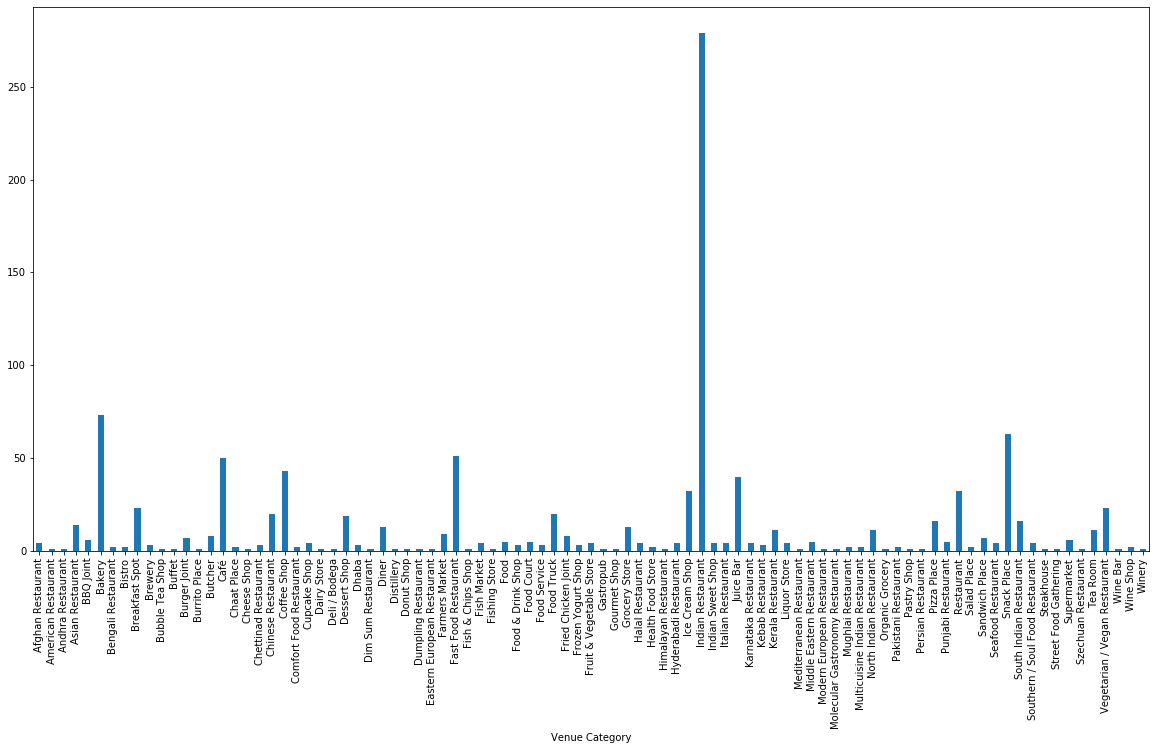

In [10]:
venuesFromFoursquareValidFood.groupby(["Venue Category"]).size().plot.bar(figsize=(20,10))

In [13]:
#Categories with occurence across all neighbourhoods

validCategories = venuesFromFoursquareValidFood.groupby(["Venue Category"]).size().reset_index(name='Counts')

In [15]:
TopValidCategories=validCategories.sort_values(by=['Counts'], ascending=False)[0:9]
TopValidCategories

,Venue Category,Counts
54,Indian Restaurant,279
5,Bakery,73
79,Snack Place,63
34,Fast Food Restaurant,51
15,Café,50
20,Coffee Shop,43
57,Juice Bar,40
53,Ice Cream Shop,32
75,Restaurant,32


In [18]:
#Filter Venues which belong to Top valid categories

filterList=TopValidCategories['Venue Category']
TopVenuesFromFoursquareValidFood=venuesFromFoursquareValidFood[venuesFromFoursquareValidFood['Venue Category'].isin(filterList)] 
print(TopVenuesFromFoursquareValidFood.shape)
TopVenuesFromFoursquareValidFood.head()

(663, 9)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Icon
4,560045,13.0291,77.6206,512ce3bfe4b053d1bd6b6263,Kanaka Sagar Restaurant,13.025799,77.629169,Indian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/in...
9,560045,13.0291,77.6206,4e4cf1e6d4c083e9648ffc57,New Krishna Sagar,13.026125,77.622722,Indian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/in...
17,560045,13.0291,77.6206,50595659e4b04e53f64976c3,Tea Shop,13.031503,77.620736,Coffee Shop,https://ss3.4sqi.net/img/categories_v2/food/co...
20,560045,13.0291,77.6206,4efee9499911b33a100c20a5,Kamal da Dhaba,13.027063,77.622548,Indian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/in...
22,560045,13.0291,77.6206,5324873c498e7393c92cb9c9,"nandhini deluxe, RT nagar",13.023767,77.614201,Indian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/in...


In [20]:
# drop venue icon column

TopVenuesFromFoursquareValidFood.drop(['Venue Icon'],axis=1, inplace=True)
TopVenuesFromFoursquareValidFood.shape

C:\Users\tmadan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(663, 8)

In [80]:
# Create dummies for Venue Category along with Neighbourhood

TopVenuesFromFoursquareValidFood.head()
DFWithVenue = TopVenuesFromFoursquareValidFood[['Neighbourhood','Venue Category']]
TopVenuesFromFoursquareValidFood_withDummies = pd.get_dummies(DFWithVenue[['Venue Category']], prefix="", prefix_sep="")
TopVenuesFromFoursquareValidFood_withDummies.insert(0,"Neighbourhood",TopVenuesFromFoursquareValidFood[['Neighbourhood']])
TopVenuesFromFoursquareValidFood_withDummies.head()

,Neighbourhood,Bakery,Café,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Juice Bar,Restaurant,Snack Place
4,560045,0,0,0,0,0,1,0,0,0
9,560045,0,0,0,0,0,1,0,0,0
17,560045,0,0,1,0,0,0,0,0,0
20,560045,0,0,0,0,0,1,0,0,0
22,560045,0,0,0,0,0,1,0,0,0


In [82]:
DFFeatures = TopVenuesFromFoursquareValidFood_withDummies.groupby('Neighbourhood').mean().reset_index()

In [83]:
DFFeatures.head()

,Neighbourhood,Bakery,Café,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Juice Bar,Restaurant,Snack Place
0,560001,0.000000,0.166667,0.000000,0.333333,0.000000,0.166667,0.000000,0.166667,0.166667
1,560003,0.080000,0.080000,0.200000,0.000000,0.040000,0.280000,0.120000,0.080000,0.120000
2,560004,0.000000,0.090909,0.000000,0.272727,0.000000,0.545455,0.000000,0.090909,0.000000
3,560005,0.120000,0.040000,0.000000,0.080000,0.040000,0.480000,0.240000,0.000000,0.000000
4,560008,0.083333,0.083333,0.166667,0.000000,0.083333,0.250000,0.083333,0.250000,0.000000


##### Perform Clustering


In [123]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

DFFeatures_clean = DFFeatures.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DFFeatures_clean)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 1, 3, 2, 1, 1, 3, 1, 3, 0])

In [124]:
DFFeatures.drop(['Cluster Labels'],axis=1, inplace=True)
DFFeatures.insert(0, 'Cluster Labels', kmeans.labels_)

In [125]:
DFFeatures.head()

,Cluster Labels,Neighbourhood,Bakery,Café,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Juice Bar,Restaurant,Snack Place
0,0,560001,0.000000,0.166667,0.000000,0.333333,0.000000,0.166667,0.000000,0.166667,0.166667
1,1,560003,0.080000,0.080000,0.200000,0.000000,0.040000,0.280000,0.120000,0.080000,0.120000
2,3,560004,0.000000,0.090909,0.000000,0.272727,0.000000,0.545455,0.000000,0.090909,0.000000
3,2,560005,0.120000,0.040000,0.000000,0.080000,0.040000,0.480000,0.240000,0.000000,0.000000
4,1,560008,0.083333,0.083333,0.166667,0.000000,0.083333,0.250000,0.083333,0.250000,0.000000


In [96]:
# Add Latitude and Longitude for Neighbourhood
cleanPOandLL.rename(columns={'pincode': "Neighbourhood"},inplace=True)
cleanPOandLL.head()

C:\Users\tmadan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,officename,Neighbourhood,longitude,latitude
52180,Arabic College S.O,560045,77.6206,13.0291
52187,Bellandur S.O,560103,77.6760,12.9298
52201,Domlur S.O,560071,77.6359,12.9611
52204,Dr. Shivarama Karanth Nagar S.O,560077,77.6293,13.0681
52206,Fraser Town S.O,560005,77.6164,13.0005


In [126]:
# merge to add latitude/longitude for each neighborhood
DFFeatures_merged = DFFeatures.join(cleanPOandLL.set_index('Neighbourhood'), on='Neighbourhood')
DFFeatures_merged.drop(['officename'],axis=1, inplace=True)
DFFeatures_merged.head()

,Cluster Labels,Neighbourhood,Bakery,Café,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Juice Bar,Restaurant,Snack Place,longitude,latitude
0,0,560001,0.000000,0.166667,0.000000,0.333333,0.000000,0.166667,0.000000,0.166667,0.166667,77.5915,12.9773
1,1,560003,0.080000,0.080000,0.200000,0.000000,0.040000,0.280000,0.120000,0.080000,0.120000,77.5709,13.0002
2,3,560004,0.000000,0.090909,0.000000,0.272727,0.000000,0.545455,0.000000,0.090909,0.000000,77.5741,12.9446
3,2,560005,0.120000,0.040000,0.000000,0.080000,0.040000,0.480000,0.240000,0.000000,0.000000,77.6164,13.0005
4,1,560008,0.083333,0.083333,0.166667,0.000000,0.083333,0.250000,0.083333,0.250000,0.000000,77.6427,12.9686


In [127]:
temp = DFFeatures_merged.drop(['Neighbourhood'],axis=1)
temp.groupby(['Cluster Labels']).mean().reset_index()

,Cluster Labels,Bakery,Café,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Juice Bar,Restaurant,Snack Place,longitude,latitude
0,0,0.049608,0.144880,0.111492,0.126265,0.145840,0.212771,0.067093,0.071090,0.070962,77.592838,12.956963
1,1,0.144243,0.037737,0.080491,0.075309,0.035572,0.385675,0.054126,0.040359,0.146488,77.596694,12.988356
2,2,0.135562,0.095313,0.067125,0.026036,0.008542,0.488150,0.083572,0.031575,0.064124,77.589150,12.929842
3,3,0.054995,0.072538,0.014784,0.166525,0.023998,0.507927,0.027095,0.073469,0.058670,77.558400,12.914700


##### Map


In [101]:
conda install folium -c conda-forge

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [128]:
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
TOR_COORDINATES = (DFFeatures_merged['latitude'].mean(), DFFeatures_merged['longitude'].mean())

map_clusters = folium.Map(location=TOR_COORDINATES, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
cluster_int = DFFeatures_merged['Cluster Labels'].apply(np.int64)

for lat, lon, poi, cluster in zip(DFFeatures_merged['latitude'], DFFeatures_merged['longitude'], DFFeatures_merged['Neighbourhood'], cluster_int):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters